# `nepy`: NEP C++ interface

This tutorial demonstrates the basic functionality of `nepy`. `nepy` interfaces directly with the `GPUMD` NEP object, and enables analysis of trained NEP models. Specifically, `nepy` exposes convenience functions for calculating per-atom descriptors, energies, forces and virials/stresses for [ASE Atoms objects](https://wiki.fysik.dtu.dk/ase/ase/atoms.html), as well as a CPU-only ASE calculator.

***Note: `nepy` only supports NEP potentials created with GPUMD version 3.3 and later***

## Calculate descriptors, energies and forces
We start by creating an `Atoms` object which will serve as our prototype system for the extent of this tutorial, and importing the `get_descriptors` and `get_potential_forces_and_virials` functions from `nepy`.

In [1]:
from calorine.nepy import get_descriptors, get_potential_forces_and_virials
from ase.build import bulk

atoms = bulk('PbTe', crystalstructure='rocksalt', a=6.7)

We can now compute the descriptors, energies, forces and virials for our system by calling `get_descriptors` and `get_potential_forces_and_virials` and passing in our system together with a path to a NEP model file (often called `nep.txt`). Here, we use a [NEP3 model for PbTe](https://gitlab.com/brucefan1983/nep-data/-/tree/main/PbTe).

In [2]:
descriptors = get_descriptors(
    atoms, 
    potential_filename='PbTe_NEP3.txt'
)

per_atom_energies, forces, virials = get_potential_forces_and_virials(
    atoms, 
    potential_filename='PbTe_NEP3.txt'
)

print(f'Shape of descriptors: {descriptors.shape}')
print(f'Energy (eV):\n {per_atom_energies}')
print(f'Forces (eV/Å):\n {forces}')
print(f'Virials (eV):\n {virials}')

Shape of descriptors: (2, 30)
Energy (eV):
 [-3.81130494 -3.86976582]
Forces (eV/Å):
 [[ 2.70616862e-16  2.85239922e-17 -1.16068684e-16]
 [-2.70616862e-16 -2.85239922e-17  1.16068684e-16]]
Virials (eV):
 [[-2.34181544e-01 -2.65703027e-16  1.22107929e-16 -2.57029410e-16
  -2.34181544e-01  2.64354885e-17  1.42924611e-16  2.64354885e-17
  -2.34181544e-01]
 [-1.28333417e-01 -4.71844785e-16  4.16333634e-17 -4.71844785e-16
  -1.28333417e-01 -8.32667268e-17  1.38777878e-17 -8.32667268e-17
  -1.28333417e-01]]


`get_descriptors` can also be called without supplying a NEP model file, in which case a dummy NEP2 model will be generated and used. The dummy model has all parameter values set to 1. *Note that this model does not differentiate different atom species.* Thus, supplying your own trained NEP model file is recommended for most applications. 

In [3]:
descriptors = get_descriptors(atoms)
print(f'Shape of descriptors: {descriptors.shape}')

Shape of descriptors: (2, 52)


## CPU-only ASE calculator
`nepy` implements a CPU-only ASE calculator to enable using trained NEP models on systems without a GPU. At the moment, the calculator only exposes functionality for calculating energies and forces. 

We use the same `Atoms` object as in the previous section, and create calculator instance by specifying the path to a NEP model file.

### Basic usage

In [4]:
from calorine.nepy import CPUNEP
from ase.build import bulk

atoms = bulk('PbTe', crystalstructure='rocksalt', a=6.7)
calc = CPUNEP('PbTe_NEP3.txt')
atoms.calc = calc

With the system and calculator defined, we can now calculate the energies and forces:

In [5]:
print('Energy (eV):', atoms.get_potential_energy())
print('Forces (eV/Å):\n', atoms.get_forces())

Energy (eV): -7.681070759348718
Forces (eV/Å):
 [[ 2.70616862e-16  2.85239922e-17 -1.16068684e-16]
 [-2.70616862e-16 -2.85239922e-17  1.16068684e-16]]


### Calculate energy-volume curve
The capabilities of the CPU-only ASE calculator is similar to those of the GPU-based ASE calculator `GPUNEP` also implemented in `calorine`. As an example, here we use the CPU calculator to calculate the energy-volume curve with the PbTe potential, which is also done in the tutorial for the [GPU-based ASE calculator](https://calorine.materialsmodeling.org/tutorials/ase_calculator.html).

Text(0, 0.5, 'Energy (eV/atom)')

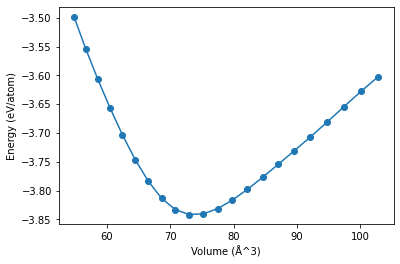

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

energies = []
volumes = []

atoms_copy = atoms.copy()
original_cell = atoms.cell.copy()

atoms_copy.calc = calc

for scale in np.arange(0.9, 1.11, 0.01):
    atoms_copy.set_cell(scale * original_cell, scale_atoms=True)
    volumes.append(atoms_copy.get_volume())
    energies.append(atoms_copy.get_potential_energy() / len(atoms_copy))

fig, ax = plt.subplots()
ax.plot(volumes, energies, '-o')
ax.set_xlabel('Volume (Å^3)')
ax.set_ylabel('Energy (eV/atom)')